# Parquet Partitioning Dataset testing

## Objective 

to test the different partition method, we can define the optimized parquet dataset structure to host global lidar dataset (e.g. GEDI) which contains more than 700 million features. The script will go through different partition strategies


### spatial partition

1. 1x1 degree grid  (36)
2. 3x3 degree grid  (4)
3. 6x6 degree grid  (1)
4. lat in 1 degree / lon in 1 degree (6*6)

Conclusion of speed (fast > slow): `lat in 1 degree / lon in 1 degree` > `1x1 degree grid` > `3x3 degree grid` > `6x6 degree grid`

### spatial and temporal partition

1. lat in 1 degree / lon in 1 degree
2. lat in 1 degree / lon in 1 degree / year / month

Conclusion of speed (fast > slow): `lat in 1 degree / lon in 1 degree / year / month` > `lat in 1 degree / lon in 1 degree`


### partition size

1. lat in 6 degree / lon in 6 degree / year / month (1 * 1 * 5 * 12) 
2. lat in 3 degree / lon in 3 degree / year / month (2 * 2 * 5 * 12)
3. lat in 1 degree / lon in 1 degree / year / month (6 * 6 * 5 * 12)
4. lat in 1 degree / lon in 0.5 degree / year / month (6 * 12 * 5 * 12)
5. lat in 0.75 degree / lon in 0.75 degree / year / month (8 * 8 * 5 * 12)
6. lat in 0.75 degree / lon in 0.6 degree / year / month (8 * 10 * 5 * 12)
7. lat in 0.75 degree / lon in 0.5 degree / year / month (8 * 12 * 5 * 12)
8. lat in 0.6 degree / lon in 0.6 degree / year / month (10 * 10 * 5 * 12)
9. lat in 0.6 degree / lon in 0.5 degree / year / month (10 * 12 * 5 * 12)
10. lat in 0.5 degree / lon in 0.5 degree / year / month (12 * 12 * 5 * 12) 
11. lat in 0.25 degree / lon in 0.25 degree / year / month (24 * 24 * 5 * 12)
12. lat in 0.1 degree / lon in 0.1 degree / year / month (60 * 60 * 5 * 12)

Conclusion of speed: optimal partition size is `lat in 1 degree / lon in 1 degree / year / month` around 2000

In [1]:
from shapely.geometry import Point, Polygon, MultiPolygon, LineString, box
import pandas as pd
import geopandas as gpd
from datetime import datetime,timedelta
import random
import matplotlib.pyplot as plt
import numpy as np

/home/opengeohub/.local/lib/python3.8/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.2-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/tmp/ipykernel_8897/4102775863.py:3: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS direc

## Part 1: spatial partition

objective: the same amount of points allocate to the different size of grid. The increased number of partition can load fewer points but the overhead and increase the time to read the metadata and search. 

In [2]:
# Functions to create tiles info
def geometry_to_1d_tile_indices(geometry):
    # Convert different geometry types to bounding box
    if isinstance(geometry, Point):
        bbox = geometry.buffer(1e-10)  # Buffer by 1 degree for points
    elif isinstance(geometry, LineString):
        bbox = geometry.buffer(1e-10)  # Buffer by 1 degree for lines
    elif isinstance(geometry, (Polygon, MultiPolygon)):
        bbox = geometry  # Bounding box for polygons and multipolygons
    else:
        raise ValueError("Unsupported geometry type")

    # Extract bounding box coordinates
    xmin, ymin, xmax, ymax = bbox.bounds
    lon_indices = range(int(xmin), int(xmax)+1)
    lat_indices = range(int(ymin), int(ymax)+1)
    grid_cells = []
    for lat_indice in lat_indices:
        for lon_indice in lon_indices:
            grid_cells.append(box(lon_indice,lat_indice,lon_indice+1,lat_indice+1))
    print(grid_cells)
    overlapping_cells = [cell for cell in grid_cells if bbox.intersects(cell)]
    tiles = []
    for tile in overlapping_cells:
        x = tile.bounds[0]
        lon = f'{str(int(x)).zfill(3)}E' if x>=0 else f'{str(-int(x)).zfill(3)}W'
        y = tile.bounds[1]
        lat = f'{str(int(y)).zfill(2)}N' if x>=0 else f'{str(-int(y)).zfill(2)}S'
        tiles.append(f"{lon}_{lat}")
    print('number of tile in the bbox:',len(grid_cells))
    print('number of tile overlapping in the polygon:',len(tiles))
    
    return tiles

def geometry_to_3d_tile_indices(geometry):
    # Convert different geometry types to bounding box
    if isinstance(geometry, Point):
        bbox = geometry.buffer(1e-10)  # Buffer by 1 degree for points
    elif isinstance(geometry, LineString):
        bbox = geometry.buffer(1e-10)  # Buffer by 1 degree for lines
    elif isinstance(geometry, (Polygon, MultiPolygon)):
        bbox = geometry  # Bounding box for polygons and multipolygons
    else:
        raise ValueError("Unsupported geometry type")

    # Extract bounding box coordinates
    xmin, ymin, xmax, ymax = bbox.bounds
    lat_indices = range(int(ymin/3)*3, int(ymax/3)*3 + 3, 3)
    lon_indices = range(int(xmin/3)*3, int(xmax/3)*3 + 3, 3)
    grid_cells = []
    for lat_indice in lat_indices:
        for lon_indice in lon_indices:
            grid_cells.append(box(lon_indice,lat_indice,lon_indice+3,lat_indice+3))
    print(grid_cells)
    overlapping_cells = [cell for cell in grid_cells if bbox.intersects(cell)]
    tiles = []
    for tile in overlapping_cells:
        x = tile.bounds[0]
        lon = f'{str(int(x)).zfill(3)}E' if x>=0 else f'{str(-int(x)).zfill(3)}W'
        y = tile.bounds[1]
        lat = f'{str(int(y)).zfill(2)}N' if x>=0 else f'{str(-int(y)).zfill(2)}S'
        tiles.append(f"{lon}_{lat}")
    print('number of tile in the bbox:',len(grid_cells))
    print('number of tile overlapping in the polygon:',len(tiles))
    
    return tiles

def geometry_to_6d_tile_indices(geometry):
    # Convert different geometry types to bounding box
    if isinstance(geometry, Point):
        bbox = geometry.buffer(1e-10)  # Buffer by 1 degree for points
    elif isinstance(geometry, LineString):
        bbox = geometry.buffer(1e-10)  # Buffer by 1 degree for lines
    elif isinstance(geometry, (Polygon, MultiPolygon)):
        bbox = geometry  # Bounding box for polygons and multipolygons
    else:
        raise ValueError("Unsupported geometry type")

    # Extract bounding box coordinates
    xmin, ymin, xmax, ymax = bbox.bounds
    lat_indices = range(int(ymin/6)*6, int(ymax/6)*6 + 6, 6)
    lon_indices = range(int(xmin/6)*6, int(xmax/6)*6 + 6, 6)
    grid_cells = []
    for lat_indice in lat_indices:
        for lon_indice in lon_indices:
            grid_cells.append(box(lon_indice,lat_indice,lon_indice+6,lat_indice+6))
    
    overlapping_cells = [cell for cell in grid_cells if bbox.intersects(cell)]
    
    print(grid_cells)
    tiles = []
    for tile in overlapping_cells:
        x = tile.bounds[0]
        lon = f'{str(int(x)).zfill(3)}E' if x>=0 else f'{str(-int(x)).zfill(3)}W'
        y = tile.bounds[1]
        lat = f'{str(int(y)).zfill(2)}N' if x>=0 else f'{str(-int(y)).zfill(2)}S'
        tiles.append(f"{lon}_{lat}")
    print('number of tile in the bbox:',len(grid_cells))
    print('number of tile overlapping in the polygon:',len(tiles))
    
    return tiles

In [3]:
def timer_tiles(geometry,partition='1degree_tile'):
    import os
    import polars as pl
    import time
    import random
    os.environ['USE_PYGEOS'] = '0'
    from pyarrow.dataset import dataset,field,parquet_dataset
    from s3fs import S3FileSystem
    import pyarrow.fs as fs
    import pyarrow.parquet as pq
    httpfs = S3FileSystem(
          endpoint_url='https://s3.eu-central-1.wasabisys.com',
          anon=True
       )
    if partition == '1degree_tile':
        geometry_to_tile_indices = geometry_to_1d_tile_indices
    elif  partition == '3degree_tile':
        geometry_to_tile_indices = geometry_to_3d_tile_indices
    elif  partition == '6degree_tile':
        geometry_to_tile_indices = geometry_to_6d_tile_indices
    aoi = gpd.GeoDataFrame({'geometry': [geometry]}, crs='EPSG:4326')
    list_of_tile = geometry_to_tile_indices(geometry)
    print(list_of_tile)
    random.seed(1000)
    object_path = f'gedi-ard/{partition}'
    pyarrow_dataset = dataset(
        source = object_path,
        format = 'parquet',
        filesystem=httpfs
    )
    start = time.time()
    t = pq.ParquetDataset(path_or_paths=object_path,
                      filesystem=httpfs,
                      filters=[(partition,'in',list_of_tile)])
    raw=t.read().to_pandas()

    print(f"extract points in {time.time() - start:.2f} s", flush=True)
    ext_time = (time.time() - start)
    print(f'number of points extracted: {len(raw)}', flush=True)
    start1 = time.time()
    gdf = gpd.GeoDataFrame(
        raw, geometry=gpd.points_from_xy(raw.longitude, raw.latitude), crs="EPSG:4326"
    )
    out_gdf = gpd.overlay(gdf, aoi, how='intersection')
    refine_time = (time.time() - start1)
    print(f"refine points in {time.time() - start1:.2f} s", flush=True)    
    print(f'number of points refined: {len(out_gdf)}', flush=True)
    print(f"total time in {time.time() - start:.2f} s", flush=True)    
    total_time = (time.time() - start)
    return ext_time, refine_time, total_time

In [4]:
def timer_lat_lon(geometry,start_date=None,end_date=None):
    import os
    import polars as pl
    import time
    os.environ['USE_PYGEOS'] = '0'
    from pyarrow.dataset import dataset,field,parquet_dataset
    from s3fs import S3FileSystem
    import pyarrow.fs as fs
    import pyarrow.parquet as pq
    httpfs = S3FileSystem(
          endpoint_url='https://s3.eu-central-1.wasabisys.com',
          anon=True
       )
    aoi = gpd.GeoDataFrame({'geometry': [geometry]}, crs='EPSG:4326')
    object_path = f'gedi-ard/lat_lon'
    pyarrow_dataset = dataset(
        source = object_path,
        format = 'parquet',
        filesystem=httpfs
    )
    start = time.time()
    xmin,ymin,xmax,ymax = geometry.bounds
    xmin=int(xmin)*100
    xmax=int(xmax)*100
    ymin=int(ymin)*100
    ymax=int(ymax)*100
    t = pq.ParquetDataset(path_or_paths=object_path,
                          filesystem=httpfs,
                          filters=[('lat','>=',ymin),('lat','<=',ymax),('lon','>=',xmin),('lon','<=',xmax)])
    raw=t.read().to_pandas()

    print(f"extract points in {time.time() - start:.2f} s", flush=True)
    ext_time = (time.time() - start)
    print(f'number of points extracted: {len(raw)}', flush=True)
    start1 = time.time()
    gdf = gpd.GeoDataFrame(
        raw, geometry=gpd.points_from_xy(raw.longitude, raw.latitude), crs="EPSG:4326"
    )
    #gdf[['latitude','longitude','geometry']].to_file(f'{partition}.gpkg',Driver='GPKG')
    out_gdf = gpd.overlay(gdf, aoi, how='intersection')
    if start_date is not None:
        out_gdf = out_gdf[out_gdf['datetime']> start_date]
    if end_date is not None:
        out_gdf = out_gdf[out_gdf['datetime']< end_date]

    refine_time = (time.time() - start1)
    #print(out_gdf)
    #out_gdf[['latitude','longitude','geometry']].to_file(f'{partition}_cut.gpkg',Driver='GPKG')
    print(f"refine points in {time.time() - start1:.2f} s", flush=True)    
    print(f'number of points refined: {len(out_gdf)}', flush=True)
    print(f"total time in {time.time() - start:.2f} s", flush=True)    
    total_time = (time.time() - start)
    return ext_time, refine_time, total_time

### Run the timer for random access

In [5]:
ext_times_1=[]
refine_times_1=[]
total_times_1=[]
for i in range(30):
    rand_point = Point(random.uniform(12,18),random.uniform(6,12))
    geometry = rand_point.buffer(1)
    ext_time, refine_time, total_time = timer_tiles(geometry,partition='1degree_tile')
    ext_times_1.append(ext_time)
    refine_times_1.append(refine_time)
    total_times_1.append(total_time)

[<POLYGON ((12 6, 12 7, 11 7, 11 6, 12 6))>, <POLYGON ((13 6, 13 7, 12 7, 12 6, 13 6))>, <POLYGON ((14 6, 14 7, 13 7, 13 6, 14 6))>, <POLYGON ((12 7, 12 8, 11 8, 11 7, 12 7))>, <POLYGON ((13 7, 13 8, 12 8, 12 7, 13 7))>, <POLYGON ((14 7, 14 8, 13 8, 13 7, 14 7))>, <POLYGON ((12 8, 12 9, 11 9, 11 8, 12 8))>, <POLYGON ((13 8, 13 9, 12 9, 12 8, 13 8))>, <POLYGON ((14 8, 14 9, 13 9, 13 8, 14 8))>]
number of tile in the bbox: 9
number of tile overlapping in the polygon: 9
['011E_06N', '012E_06N', '013E_06N', '011E_07N', '012E_07N', '013E_07N', '011E_08N', '012E_08N', '013E_08N']
extract points in 2.79 s
number of points extracted: 901775
refine points in 2.36 s
number of points refined: 412871
total time in 5.16 s
[<POLYGON ((16 9, 16 10, 15 10, 15 9, 16 9))>, <POLYGON ((17 9, 17 10, 16 10, 16 9, 17 9))>, <POLYGON ((18 9, 18 10, 17 10, 17 9, 18 9))>, <POLYGON ((16 10, 16 11, 15 11, 15 10, 16 10))>, <POLYGON ((17 10, 17 11, 16 11, 16 10, 17 10))>, <POLYGON ((18 10, 18 11, 17 11, 17 10, 18 10

In [6]:
ext_times_3=[]
refine_times_3=[]
total_times_3=[]
for i in range(30):
    rand_point = Point(random.uniform(12,18),random.uniform(6,12))
    geometry = rand_point.buffer(1)
    ext_time, refine_time, total_time = timer_tiles(geometry,partition='3degree_tile')
    ext_times_3.append(ext_time)
    refine_times_3.append(refine_time)
    total_times_3.append(total_time)

[<POLYGON ((18 9, 18 12, 15 12, 15 9, 18 9))>]
number of tile in the bbox: 1
number of tile overlapping in the polygon: 1
['015E_09N']
extract points in 6.78 s
number of points extracted: 1368577
refine points in 2.44 s
number of points refined: 446175
total time in 9.22 s
[<POLYGON ((18 9, 18 12, 15 12, 15 9, 18 9))>]
number of tile in the bbox: 1
number of tile overlapping in the polygon: 1
['015E_09N']
extract points in 6.76 s
number of points extracted: 1368577
refine points in 2.48 s
number of points refined: 446175
total time in 9.25 s
[<POLYGON ((18 9, 18 12, 15 12, 15 9, 18 9))>]
number of tile in the bbox: 1
number of tile overlapping in the polygon: 1
['015E_09N']
extract points in 6.63 s
number of points extracted: 1368577
refine points in 2.92 s
number of points refined: 446175
total time in 9.55 s
[<POLYGON ((18 9, 18 12, 15 12, 15 9, 18 9))>]
number of tile in the bbox: 1
number of tile overlapping in the polygon: 1
['015E_09N']
extract points in 9.92 s
number of points e

In [7]:
ext_times_6=[]
refine_times_6=[]
total_times_6=[]
for i in range(30):
    rand_point = Point(random.uniform(12,18),random.uniform(6,12))
    geometry = rand_point.buffer(1)
    ext_time, refine_time, total_time = timer_tiles(geometry,partition='6degree_tile')
    ext_times_6.append(ext_time)
    refine_times_6.append(refine_time)
    total_times_6.append(total_time)

[<POLYGON ((18 6, 18 12, 12 12, 12 6, 18 6))>]
number of tile in the bbox: 1
number of tile overlapping in the polygon: 1
['012E_06N']
extract points in 17.37 s
number of points extracted: 5441920
refine points in 6.27 s
number of points refined: 446175
total time in 23.65 s
[<POLYGON ((18 6, 18 12, 12 12, 12 6, 18 6))>]
number of tile in the bbox: 1
number of tile overlapping in the polygon: 1
['012E_06N']
extract points in 24.61 s
number of points extracted: 5441920
refine points in 5.82 s
number of points refined: 446175
total time in 30.43 s
[<POLYGON ((18 6, 18 12, 12 12, 12 6, 18 6))>]
number of tile in the bbox: 1
number of tile overlapping in the polygon: 1
['012E_06N']
extract points in 24.54 s
number of points extracted: 5441920
refine points in 5.81 s
number of points refined: 446175
total time in 30.36 s
[<POLYGON ((18 6, 18 12, 12 12, 12 6, 18 6))>]
number of tile in the bbox: 1
number of tile overlapping in the polygon: 1
['012E_06N']
extract points in 18.16 s
number of p

In [8]:
ext_times_lat_lon=[]
refine_times_lat_lon=[]
total_times_lat_lon=[]
for i in range(30):
    rand_point = Point(random.uniform(12,18),random.uniform(6,12))
    geometry = rand_point.buffer(1)
    ext_time, refine_time, total_time = timer_lat_lon(geometry)
    ext_times_lat_lon.append(ext_time)
    refine_times_lat_lon.append(refine_time)
    total_times_lat_lon.append(total_time)

extract points in 6.56 s
number of points extracted: 3107867
refine points in 6.15 s
number of points refined: 1100249
total time in 12.72 s
extract points in 6.14 s
number of points extracted: 1747983
refine points in 4.16 s
number of points refined: 881423
total time in 10.30 s
extract points in 4.91 s
number of points extracted: 1938177
refine points in 3.56 s
number of points refined: 650875
total time in 8.48 s
extract points in 3.46 s
number of points extracted: 1053406
refine points in 2.26 s
number of points refined: 479603
total time in 5.73 s
extract points in 6.13 s
number of points extracted: 2536033
refine points in 4.66 s
number of points refined: 814653
total time in 10.80 s
extract points in 7.81 s
number of points extracted: 3153297
refine points in 6.61 s
number of points refined: 1213879
total time in 14.42 s
extract points in 6.46 s
number of points extracted: 2693238
refine points in 4.77 s
number of points refined: 813623
total time in 11.24 s
extract points in 6.

### Plot 

#### Extract time
read the metadata + search the partition in the dataset + loading the data from the cloud server to a dataframe

#### Refine time
dataframe intersects with the original polygon to get the points in area of interest.

/tmp/ipykernel_11847/2338193712.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['1x1 degree tile','3x3 degree tile','6x6 degree tile'])


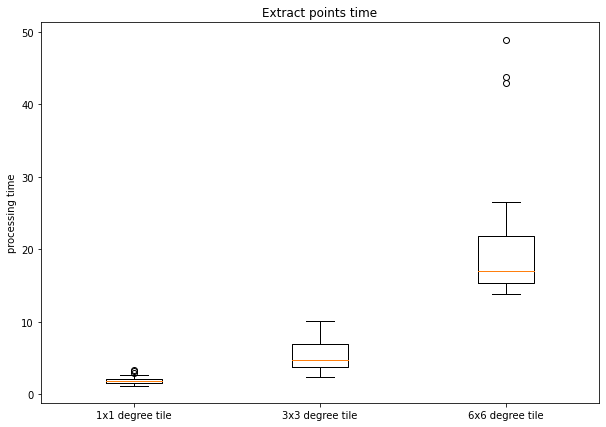

In [52]:
fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)

data = [ext_times_1,ext_times_3,ext_times_6,ext_times_lat_lon]

# x-axis labels
ax.set_xticklabels(['1x1 degree tile','3x3 degree tile','6x6 degree tile','ext_times_lat_lon'])
# Creating plot
plt.boxplot(data)

plt.title("Extract points time")
ax.set_ylabel('processing time')

# show plot
plt.show()

In [ ]:
fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)

data = [refine_times_1,refine_times_3,refine_times_6,refine_times_lat_lon]

# x-axis labels
ax.set_xticklabels(['1x1 degree tile','3x3 degree tile','6x6 degree tile','lat lon partition'])
# Creating plot
plt.boxplot(data)


plt.title("Refine points time")
ax.set_ylabel('processing time')

# show plot
plt.show()

NameError: name 'total_times_1' is not defined

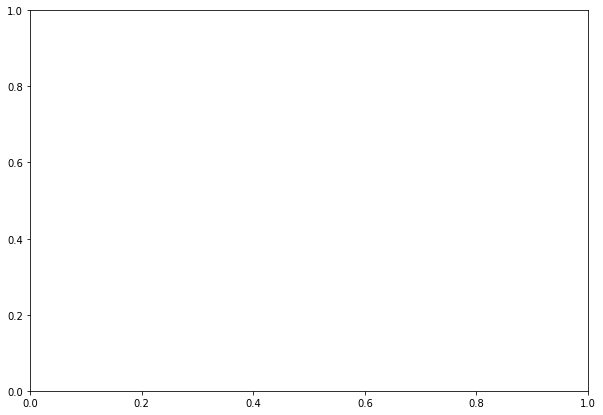

In [9]:
fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)

data = [total_times_1,total_times_3,total_times_6,total_times_lat_lon]

# x-axis labels
ax.set_xticklabels(['1x1 degree tile','3x3 degree tile','6x6 degree tile','lat lon partition'])
# Creating plot
plt.boxplot(data)


plt.title("Extract time + refine time")
ax.set_ylabel('processing time')

# show plot
plt.show()

## Part 2: spatial and temporal partition

Objective: see if adding temporal partition can increase the speed of queries

In [22]:
# function to give partition for year month
def timer_lat_lon_year_month(geometry,degree,start_date,end_date,imbalance=False):
    import os
    import polars as pl
    import time
    os.environ['USE_PYGEOS'] = '0'
    from pyarrow.dataset import dataset,field,parquet_dataset
    from s3fs import S3FileSystem
    import pyarrow.fs as fs
    import pyarrow.parquet as pq
    httpfs = S3FileSystem(
          endpoint_url='https://s3.eu-central-1.wasabisys.com',
          anon=True
       )
    aoi = gpd.GeoDataFrame({'geometry': [geometry]}, crs='EPSG:4326')
    if not imbalance:
        object_path = f'gedi-ard/lat_lon_{degree}degree_year_month'
        xmin,ymin,xmax,ymax = geometry.bounds
        xmin=int(xmin/degree)*degree*100
        xmax=int(xmax/degree)*degree*100
        ymin=int(ymin/degree)*degree*100
        ymax=int(ymax/degree)*degree*100
        print(xmin,xmax,ymin,ymax)
    else:
        degree_lat = degree[0] 
        degree_lon = degree[1]
        object_path = f'gedi-ard/lat_{degree_lat}degree_lon_{degree_lon}degree_year_month'
        xmin,ymin,xmax,ymax = geometry.bounds
        xmin=int(xmin/degree_lon)*degree_lon*100
        xmax=int(xmax/degree_lon)*degree_lon*100
        ymin=int(ymin/degree_lat)*degree_lat*100
        ymax=int(ymax/degree_lat)*degree_lat*100
        print(xmin,xmax,ymin,ymax)

    pyarrow_dataset = dataset(
        source = object_path,
        format = 'parquet',
        filesystem=httpfs
    )
    start = time.time()

    years = [i for i in range(start_date.year,end_date.year+1,1)]
    if len(years)>1:
        t=[]
        for ind, year in enumerate(years):
            if ind==0:
                tmp = pq.ParquetDataset(path_or_paths=object_path,
                                      filesystem=httpfs,
                                      filters=[('lat','>=',ymin),('lat','<=',ymax),('lon','>=',xmin),('lon','<=',xmax)
                                              ,('year','=',year),('month','>=',start_date.month)])
                t.append(tmp)
            elif ind == len(years)-1:
                tmp = pq.ParquetDataset(path_or_paths=object_path,
                      filesystem=httpfs,
                      filters=[('lat','>=',ymin),('lat','<=',ymax),('lon','>=',xmin),('lon','<=',xmax)
                              ,('year','=',year),('month','<=',end_date.month)])
                t.append(tmp)
            else:
                tmp = pq.ParquetDataset(path_or_paths=object_path,
                      filesystem=httpfs,
                      filters=[('lat','>=',ymin),('lat','<=',ymax),('lon','>=',xmin),('lon','<=',xmax)
                              ,('year','=',year)])     
                t.append(tmp)
        raw = pd.concat([i.read().to_pandas() for i in t])
    else:
        t = pq.ParquetDataset(path_or_paths=object_path,
          filesystem=httpfs,
          filters=[('lat','>=',ymin),('lat','<=',ymax),('lon','>=',xmin),('lon','<=',xmax)
                  ,('year','=',years[0]),('month','<=',end_date.month),('month','>=',start_date.month)])  
                                      
        raw=t.read().to_pandas()

    print(f"extract points in {time.time() - start:.2f} s", flush=True)
    ext_time = (time.time() - start)
    print(f'number of points extracted: {len(raw)}', flush=True)
    start1 = time.time()
    gdf = gpd.GeoDataFrame(
        raw, geometry=gpd.points_from_xy(raw.longitude, raw.latitude), crs="EPSG:4326"
    )
    out_gdf = gpd.overlay(gdf, aoi, how='intersection')
    
    if start_date is not None:
        out_gdf = out_gdf[out_gdf['datetime']> start_date]
    if end_date is not None:
        out_gdf = out_gdf[out_gdf['datetime']< end_date]

    refine_time = (time.time() - start1)
    print(f"refine points in {time.time() - start1:.2f} s", flush=True)    
    print(f'number of points refined: {len(out_gdf)}', flush=True)
    print(f"total time in {time.time() - start:.2f} s", flush=True)    
    total_time = (time.time() - start)
    return ext_time, refine_time, total_time

In [24]:
ext_times_lat_lon_baseline=[]
refine_times_lat_lon_baseline=[]
total_times_lat_lon_baseline=[]
for i in range(30):
    start_date = datetime(2020,random.randint(1,12),random.randint(1,29))
    end_date = start_date  + timedelta(random.randint(1,365*2))
    rand_point = Point(random.uniform(12,18),random.uniform(6,12))
    geometry = rand_point.buffer(1)
    ext_time, refine_time, total_time = timer_lat_lon(geometry,start_date,end_date)
    ext_times_lat_lon_baseline.append(ext_time)
    refine_times_lat_lon_baseline.append(refine_time)
    total_times_lat_lon_baseline.append(total_time)

1100 1300 900 1100
extract points in 3.49 s
number of points extracted: 1250697
refine points in 3.81 s
number of points refined: 0
total time in 7.31 s
1500 1700 900 1100
extract points in 8.44 s
number of points extracted: 3107867
refine points in 8.09 s
number of points refined: 356456
total time in 16.52 s
1300 1500 700 900
extract points in 7.12 s
number of points extracted: 2474873
refine points in 6.06 s
number of points refined: 218436
total time in 13.18 s
1300 1500 500 700
extract points in 9.41 s
number of points extracted: 2438962
refine points in 8.78 s
number of points refined: 610255
total time in 18.19 s
1500 1700 800 1000
extract points in 11.14 s
number of points extracted: 2725903
refine points in 6.70 s
number of points refined: 445790
total time in 17.84 s
1500 1700 800 1000
extract points in 11.51 s
number of points extracted: 2725903
refine points in 6.76 s
number of points refined: 295094
total time in 18.27 s
1600 1800 500 700
extract points in 4.21 s
number of

In [26]:
degree=1
ext_times_lat_lon_year_month_1=[]
refine_times_lat_lon_year_month_1=[]
total_times_lat_lon_year_month_1=[]
for i in range(30):
    start_date = datetime(2020,random.randint(1,12),random.randint(1,29))
    end_date = start_date  + timedelta(random.randint(1,365*2))
    rand_point = Point(random.uniform(12,18),random.uniform(6,12))
    geometry = rand_point.buffer(1)
    ext_time, refine_time, total_time = timer_lat_lon_year_month(geometry,degree,start_date,end_date)
    ext_times_lat_lon_year_month_1.append(ext_time)
    refine_times_lat_lon_year_month_1.append(refine_time)
    total_times_lat_lon_year_month_1.append(total_time)

1400 1600 500 700
extract points in 7.76 s
number of points extracted: 799044
refine points in 2.09 s
number of points refined: 286729
total time in 9.86 s
1400 1600 900 1100
extract points in 2.92 s
number of points extracted: 394053
refine points in 1.38 s
number of points refined: 178070
total time in 4.30 s
1600 1800 700 900
extract points in 2.44 s
number of points extracted: 214018
refine points in 0.58 s
number of points refined: 29654
total time in 3.02 s
1100 1300 500 700
extract points in 4.21 s
number of points extracted: 514246
refine points in 1.40 s
number of points refined: 144665
total time in 5.62 s
1500 1700 1000 1200
extract points in 5.11 s
number of points extracted: 729015
refine points in 2.73 s
number of points refined: 382349
total time in 7.84 s
1600 1800 600 800
extract points in 4.69 s
number of points extracted: 563132
refine points in 1.74 s
number of points refined: 264184
total time in 6.43 s
1300 1500 1000 1200
extract points in 2.59 s
number of points 

/tmp/ipykernel_216/3643035547.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['lat lon partition without year month (baseline)','lat lon partition year month'])


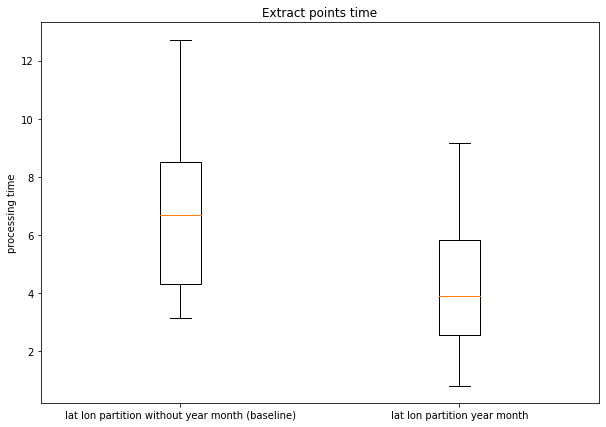

In [27]:
fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)

data = [ext_times_lat_lon_baseline,ext_times_lat_lon_year_month_1]

# x-axis labels
ax.set_xticklabels(['lat lon partition without year month (baseline)','lat lon partition year month'])
# Creating plot
plt.boxplot(data)

plt.title("Extract points time")
ax.set_ylabel('processing time')

# show plot
plt.show()

/tmp/ipykernel_216/2283949407.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['lat lon partition without year month (baseline)','lat lon partition year month'])


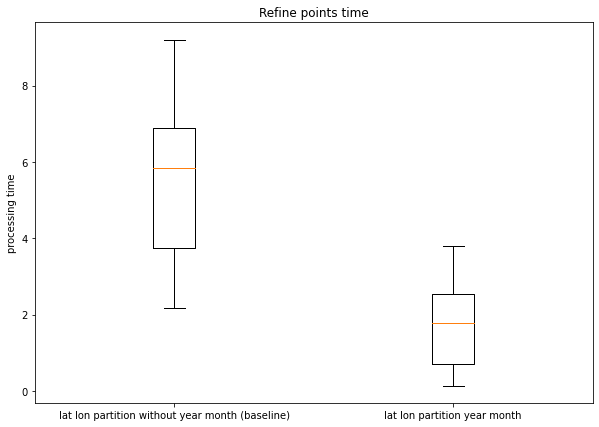

In [28]:
fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)

data = [refine_times_lat_lon_baseline,refine_times_lat_lon_year_month_1]

# x-axis labels
ax.set_xticklabels(['lat lon partition without year month (baseline)','lat lon partition year month'])
# Creating plot
plt.boxplot(data)


plt.title("Refine points time")
ax.set_ylabel('processing time')

# show plot
plt.show()

/tmp/ipykernel_216/2528268169.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['lat lon partition without year month (baseline)','lat lon partition year month'])


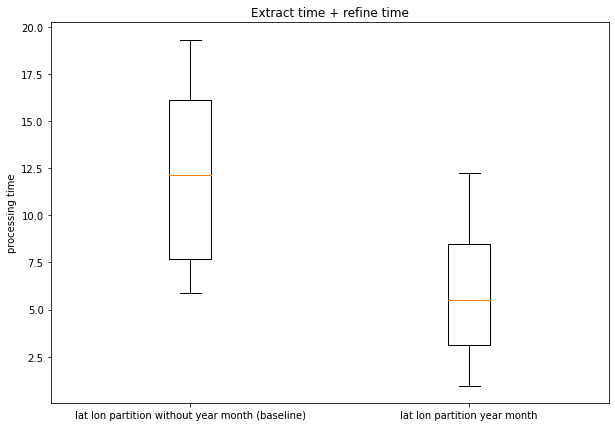

In [29]:
fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)

data = [total_times_lat_lon_baseline,total_times_lat_lon_year_month_1]

# x-axis labels
ax.set_xticklabels(['lat lon partition without year month (baseline)','lat lon partition year month'])
# Creating plot
plt.boxplot(data)


plt.title("Extract time + refine time")
ax.set_ylabel('processing time')

# show plot
plt.show()

## Part3: Partition Size

Objective: partition size has the impact on reading metadata. It can be an ultimate way to optimize the structure by introducing the optimal partition size.

In [30]:
degree=0.1
ext_times_lat_lon_year_month_01=[]
refine_times_lat_lon_year_month_01=[]
total_times_lat_lon_year_month_01=[]
for i in range(30):
    start_date = datetime(2020,random.randint(1,12),random.randint(1,29))
    end_date = start_date  + timedelta(random.randint(1,365*2))
    rand_point = Point(random.uniform(12,18),random.uniform(6,12))
    geometry = rand_point.buffer(1)
    ext_time, refine_time, total_time = timer_lat_lon_year_month(geometry,degree,start_date,end_date)
    ext_times_lat_lon_year_month_01.append(ext_time)
    refine_times_lat_lon_year_month_01.append(refine_time)
    total_times_lat_lon_year_month_01.append(total_time)

1310.0000000000002 1510.0000000000002 990.0 1190.0
extract points in 27.79 s
number of points extracted: 83609
refine points in 0.37 s
number of points refined: 48030
total time in 28.17 s
1510.0000000000002 1710.0000000000002 670.0 870.0000000000001
extract points in 38.15 s
number of points extracted: 234233
refine points in 1.18 s
number of points refined: 177011
total time in 39.34 s
1520.0 1720.0 590.0 790.0
extract points in 57.88 s
number of points extracted: 370249
refine points in 1.63 s
number of points refined: 225361
total time in 59.51 s
1660.0000000000002 1860.0000000000002 520.0 720.0
extract points in 22.85 s
number of points extracted: 81516
refine points in 0.46 s
number of points refined: 74499
total time in 23.31 s
1510.0000000000002 1710.0000000000002 650.0 850.0
extract points in 30.74 s
number of points extracted: 233777
refine points in 1.12 s
number of points refined: 150432
total time in 31.86 s
1330.0 1530.0 770.0 970.0000000000001
extract points in 61.15 s
n

In [31]:
degree=0.25
ext_times_lat_lon_year_month_025=[]
refine_times_lat_lon_year_month_025=[]
total_times_lat_lon_year_month_025=[]
for i in range(30):
    start_date = datetime(2020,random.randint(1,12),random.randint(1,29))
    end_date = start_date  + timedelta(random.randint(1,365*2))
    rand_point = Point(random.uniform(12,18),random.uniform(6,12))
    geometry = rand_point.buffer(1)
    ext_time, refine_time, total_time = timer_lat_lon_year_month(geometry,degree,start_date,end_date)
    ext_times_lat_lon_year_month_025.append(ext_time)
    refine_times_lat_lon_year_month_025.append(refine_time)
    total_times_lat_lon_year_month_025.append(total_time)

1325.0 1525.0 575.0 775.0
extract points in 20.37 s
number of points extracted: 659382
refine points in 3.01 s
number of points refined: 465459
total time in 23.38 s
1425.0 1625.0 750.0 950.0
extract points in 15.14 s
number of points extracted: 321526
refine points in 1.28 s
number of points refined: 199130
total time in 16.42 s
1525.0 1725.0 775.0 975.0
extract points in 12.02 s
number of points extracted: 291636
refine points in 1.14 s
number of points refined: 149634
total time in 13.16 s
1200.0 1400.0 800.0 1000.0
extract points in 9.87 s
number of points extracted: 207906
refine points in 0.93 s
number of points refined: 129674
total time in 10.80 s
1175.0 1375.0 1075.0 1275.0
extract points in 8.29 s
number of points extracted: 111469
refine points in 0.62 s
number of points refined: 88092
total time in 8.92 s
1225.0 1425.0 975.0 1175.0
extract points in 4.32 s
number of points extracted: 31256
refine points in 0.19 s
number of points refined: 9308
total time in 4.51 s
1175.0 13

In [32]:
degree=0.5
ext_times_lat_lon_year_month_05=[]
refine_times_lat_lon_year_month_05=[]
total_times_lat_lon_year_month_05=[]
for i in range(30):
    start_date = datetime(2020,random.randint(1,12),random.randint(1,29))
    end_date = start_date  + timedelta(random.randint(1,365*2))
    rand_point = Point(random.uniform(12,18),random.uniform(6,12))
    geometry = rand_point.buffer(1)
    ext_time, refine_time, total_time = timer_lat_lon_year_month(geometry,degree,start_date,end_date)
    ext_times_lat_lon_year_month_05.append(ext_time)
    refine_times_lat_lon_year_month_05.append(refine_time)
    total_times_lat_lon_year_month_05.append(total_time)

1200.0 1400.0 900.0 1100.0
extract points in 8.14 s
number of points extracted: 313180
refine points in 0.89 s
number of points refined: 99997
total time in 9.03 s
1550.0 1750.0 800.0 1000.0
extract points in 9.12 s
number of points extracted: 524468
refine points in 1.90 s
number of points refined: 238452
total time in 11.02 s
1200.0 1400.0 550.0 750.0
extract points in 4.31 s
number of points extracted: 350060
refine points in 1.33 s
number of points refined: 181937
total time in 5.65 s
1150.0 1350.0 700.0 900.0
extract points in 9.22 s
number of points extracted: 525419
refine points in 2.08 s
number of points refined: 270593
total time in 11.30 s
1600.0 1800.0 900.0 1100.0
extract points in 6.49 s
number of points extracted: 436941
refine points in 1.80 s
number of points refined: 233395
total time in 8.29 s
1100.0 1300.0 850.0 1050.0
extract points in 7.50 s
number of points extracted: 339834
refine points in 1.55 s
number of points refined: 227028
total time in 9.05 s
1350.0 1550

In [33]:
degree=3
ext_times_lat_lon_year_month_3=[]
refine_times_lat_lon_year_month_3=[]
total_times_lat_lon_year_month_3=[]
for i in range(30):
    start_date = datetime(2020,random.randint(1,12),random.randint(1,29))
    end_date = start_date  + timedelta(random.randint(1,365*2))
    rand_point = Point(random.uniform(12,18),random.uniform(6,12))
    geometry = rand_point.buffer(1)
    ext_time, refine_time, total_time = timer_lat_lon_year_month(geometry,degree,start_date,end_date)
    ext_times_lat_lon_year_month_3.append(ext_time)
    refine_times_lat_lon_year_month_3.append(refine_time)
    total_times_lat_lon_year_month_3.append(total_time)

1200 1500 900 900
extract points in 4.15 s
number of points extracted: 1011928
refine points in 1.38 s
number of points refined: 38602
total time in 5.53 s
900 1200 600 900
extract points in 3.46 s
number of points extracted: 674270
refine points in 1.10 s
number of points refined: 44685
total time in 4.56 s
900 1200 600 900
extract points in 7.27 s
number of points extracted: 1616368
refine points in 2.75 s
number of points refined: 163390
total time in 10.03 s
900 1200 600 600
extract points in 5.02 s
number of points extracted: 1139479
refine points in 2.11 s
number of points refined: 167569
total time in 7.14 s
1500 1500 600 900
extract points in 7.41 s
number of points extracted: 2051760
refine points in 3.65 s
number of points refined: 272578
total time in 11.06 s
1200 1500 900 1200
extract points in 5.47 s
number of points extracted: 1569581
refine points in 2.66 s
number of points refined: 292425
total time in 8.13 s
1500 1500 900 900
extract points in 7.81 s
number of points e

In [34]:
degree=6
ext_times_lat_lon_year_month_6=[]
refine_times_lat_lon_year_month_6=[]
total_times_lat_lon_year_month_6=[]
for i in range(30):
    start_date = datetime(2020,random.randint(1,12),random.randint(1,29))
    end_date = start_date  + timedelta(random.randint(1,365*2))
    rand_point = Point(random.uniform(12,18),random.uniform(6,12))
    geometry = rand_point.buffer(1)
    ext_time, refine_time, total_time = timer_lat_lon_year_month(geometry,degree,start_date,end_date)
    ext_times_lat_lon_year_month_6.append(ext_time)
    refine_times_lat_lon_year_month_6.append(refine_time)
    total_times_lat_lon_year_month_6.append(total_time)

1200 1200 600 1200
extract points in 12.26 s
number of points extracted: 4091567
refine points in 6.47 s
number of points refined: 371070
total time in 18.73 s
1200 1200 600 1200
extract points in 7.48 s
number of points extracted: 1087475
refine points in 1.28 s
number of points refined: 0
total time in 8.77 s
1200 1800 600 600
extract points in 9.05 s
number of points extracted: 2264046
refine points in 3.06 s
number of points refined: 74001
total time in 12.11 s
600 1200 600 600
extract points in 11.39 s
number of points extracted: 2115637
refine points in 3.06 s
number of points refined: 131251
total time in 14.45 s
1200 1200 600 600
extract points in 5.28 s
number of points extracted: 1464539
refine points in 2.53 s
number of points refined: 139429
total time in 7.82 s
1200 1200 600 600
extract points in 2.71 s
number of points extracted: 531233
refine points in 0.49 s
number of points refined: 487
total time in 3.21 s
1200 1200 0 600
extract points in 10.31 s
number of points ext

In [35]:
degree=[0.6,0.5]
ext_times_lat_lon_year_month_0605=[]
refine_times_lat_lon_year_month_0605=[]
total_times_lat_lon_year_month_0605=[]
for i in range(30):
    start_date = datetime(2020,random.randint(1,12),random.randint(1,29))
    end_date = start_date  + timedelta(random.randint(1,365*2))
    rand_point = Point(random.uniform(12,18),random.uniform(6,12))
    geometry = rand_point.buffer(1)
    ext_time, refine_time, total_time = timer_lat_lon_year_month(geometry,degree,start_date,end_date,imbalance=True)
    ext_times_lat_lon_year_month_0605.append(ext_time)
    refine_times_lat_lon_year_month_0605.append(refine_time)
    total_times_lat_lon_year_month_0605.append(total_time)

1550.0 1750.0 719.9999999999999 960.0
extract points in 3.50 s
number of points extracted: 144654
refine points in 0.30 s
number of points refined: 33770
total time in 3.81 s
1500.0 1700.0 960.0 1200.0
extract points in 11.65 s
number of points extracted: 782559
refine points in 2.40 s
number of points refined: 389952
total time in 14.05 s
1650.0 1850.0 1019.9999999999999 1200.0
extract points in 1.60 s
number of points extracted: 39825
refine points in 0.15 s
number of points refined: 27534
total time in 1.76 s
1100.0 1300.0 480.0 719.9999999999999
extract points in 3.93 s
number of points extracted: 94534
refine points in 0.19 s
number of points refined: 20317
total time in 4.12 s
1150.0 1350.0 660.0 900.0
extract points in 3.93 s
number of points extracted: 289314
refine points in 1.07 s
number of points refined: 146009
total time in 5.00 s
1650.0 1850.0 719.9999999999999 900.0
extract points in 3.58 s
number of points extracted: 90183
refine points in 0.38 s
number of points refine

In [36]:
degree=[0.6,0.6]
ext_times_lat_lon_year_month_0606=[]
refine_times_lat_lon_year_month_0606=[]
total_times_lat_lon_year_month_0606=[]
for i in range(30):
    start_date = datetime(2020,random.randint(1,12),random.randint(1,29))
    end_date = start_date  + timedelta(random.randint(1,365*2))
    rand_point = Point(random.uniform(12,18),random.uniform(6,12))
    geometry = rand_point.buffer(1)
    ext_time, refine_time, total_time = timer_lat_lon_year_month(geometry,degree,start_date,end_date,imbalance=True)
    ext_times_lat_lon_year_month_0606.append(ext_time)
    refine_times_lat_lon_year_month_0606.append(refine_time)
    total_times_lat_lon_year_month_0606.append(total_time)


1500.0 1680.0 719.9999999999999 900.0
extract points in 13.39 s
number of points extracted: 514060
refine points in 2.18 s
number of points refined: 365689
total time in 15.57 s
1620.0 1859.9999999999998 540.0 719.9999999999999
extract points in 2.20 s
number of points extracted: 72049
refine points in 0.28 s
number of points refined: 43065
total time in 2.48 s
1500.0 1680.0 719.9999999999999 900.0
extract points in 8.46 s
number of points extracted: 509223
refine points in 2.06 s
number of points refined: 336048
total time in 10.52 s
1080.0 1260.0 840.0 1080.0
extract points in 5.30 s
number of points extracted: 267040
refine points in 0.90 s
number of points refined: 119675
total time in 6.21 s
1439.9999999999998 1620.0 1019.9999999999999 1260.0
extract points in 9.19 s
number of points extracted: 395528
refine points in 1.96 s
number of points refined: 280913
total time in 11.15 s
1320.0 1560.0 600.0 780.0
extract points in 11.88 s
number of points extracted: 830760
refine points in

In [37]:
degree=[0.75,0.5]
ext_times_lat_lon_year_month_07505=[]
refine_times_lat_lon_year_month_07505=[]
total_times_lat_lon_year_month_07505=[]
for i in range(30):
    start_date = datetime(2020,random.randint(1,12),random.randint(1,29))
    end_date = start_date  + timedelta(random.randint(1,365*2))
    rand_point = Point(random.uniform(12,18),random.uniform(6,12))
    geometry = rand_point.buffer(1)
    ext_time, refine_time, total_time = timer_lat_lon_year_month(geometry,degree,start_date,end_date,imbalance=True)
    ext_times_lat_lon_year_month_07505.append(ext_time)
    refine_times_lat_lon_year_month_07505.append(refine_time)
    total_times_lat_lon_year_month_07505.append(total_time)

1200.0 1400.0 1050.0 1275.0
extract points in 4.36 s
number of points extracted: 150656
refine points in 0.60 s
number of points refined: 81464
total time in 4.96 s
1300.0 1500.0 675.0 900.0
extract points in 11.40 s
number of points extracted: 818528
refine points in 2.30 s
number of points refined: 249318
total time in 13.70 s
1600.0 1800.0 900.0 1050.0
extract points in 12.65 s
number of points extracted: 742494
refine points in 2.91 s
number of points refined: 510547
total time in 15.56 s
1400.0 1600.0 675.0 900.0
extract points in 2.92 s
number of points extracted: 185945
refine points in 0.42 s
number of points refined: 55172
total time in 3.35 s
1450.0 1650.0 525.0 675.0
extract points in 10.30 s
number of points extracted: 458355
refine points in 1.81 s
number of points refined: 267959
total time in 12.11 s
1300.0 1500.0 525.0 750.0
extract points in 2.60 s
number of points extracted: 130761
refine points in 0.31 s
number of points refined: 40251
total time in 2.91 s
1450.0 165

In [38]:
degree=[0.75,0.6]
ext_times_lat_lon_year_month_07506=[]
refine_times_lat_lon_year_month_07506=[]
total_times_lat_lon_year_month_07506=[]
for i in range(30):
    start_date = datetime(2020,random.randint(1,12),random.randint(1,29))
    end_date = start_date  + timedelta(random.randint(1,365*2))
    rand_point = Point(random.uniform(12,18),random.uniform(6,12))
    geometry = rand_point.buffer(1)
    ext_time, refine_time, total_time = timer_lat_lon_year_month(geometry,degree,start_date,end_date,imbalance=True)
    ext_times_lat_lon_year_month_07506.append(ext_time)
    refine_times_lat_lon_year_month_07506.append(refine_time)
    total_times_lat_lon_year_month_07506.append(total_time)

1080.0 1320.0 450.0 675.0
extract points in 2.26 s
number of points extracted: 149557
refine points in 0.37 s
number of points refined: 38765
total time in 2.64 s
1380.0 1560.0 750.0 975.0
extract points in 11.68 s
number of points extracted: 604095
refine points in 1.57 s
number of points refined: 176931
total time in 13.26 s
1500.0 1680.0 600.0 825.0
extract points in 1.91 s
number of points extracted: 44149
refine points in 0.09 s
number of points refined: 5563
total time in 2.00 s
1080.0 1320.0 975.0 1200.0
extract points in 2.81 s
number of points extracted: 151330
refine points in 0.72 s
number of points refined: 59289
total time in 3.53 s
1560.0 1739.9999999999998 750.0 975.0
extract points in 4.54 s
number of points extracted: 282193
refine points in 0.84 s
number of points refined: 99224
total time in 5.38 s
1380.0 1620.0 525.0 675.0
extract points in 9.04 s
number of points extracted: 674808
refine points in 2.21 s
number of points refined: 335766
total time in 11.26 s
1680.0

In [39]:
degree=[0.75,0.75]
ext_times_lat_lon_year_month_075075=[]
refine_times_lat_lon_year_month_075075=[]
total_times_lat_lon_year_month_075075=[]
for i in range(30):
    start_date = datetime(2020,random.randint(1,12),random.randint(1,29))
    end_date = start_date  + timedelta(random.randint(1,365*2))
    rand_point = Point(random.uniform(12,18),random.uniform(6,12))
    geometry = rand_point.buffer(1)
    ext_time, refine_time, total_time = timer_lat_lon_year_month(geometry,degree,start_date,end_date,imbalance=True)
    ext_times_lat_lon_year_month_075075.append(ext_time)
    refine_times_lat_lon_year_month_075075.append(refine_time)
    total_times_lat_lon_year_month_075075.append(total_time)

1125.0 1350.0 600.0 825.0
extract points in 2.15 s
number of points extracted: 184821
refine points in 0.70 s
number of points refined: 57766
total time in 2.86 s
1500.0 1725.0 900.0 1125.0
extract points in 14.19 s
number of points extracted: 843398
refine points in 2.50 s
number of points refined: 329914
total time in 16.70 s
1275.0 1500.0 975.0 1200.0
extract points in 3.25 s
number of points extracted: 174867
refine points in 0.33 s
number of points refined: 42512
total time in 3.58 s
1275.0 1500.0 450.0 675.0
extract points in 5.81 s
number of points extracted: 653246
refine points in 2.45 s
number of points refined: 388782
total time in 8.26 s
1425.0 1575.0 1050.0 1275.0
extract points in 1.61 s
number of points extracted: 106343
refine points in 0.29 s
number of points refined: 52139
total time in 1.90 s
1500.0 1650.0 600.0 825.0
extract points in 5.15 s
number of points extracted: 360627
refine points in 1.16 s
number of points refined: 163045
total time in 6.31 s
1125.0 1350.0

In [40]:
degree=[1.0,0.5]
ext_times_lat_lon_year_month_105=[]
refine_times_lat_lon_year_month_105=[]
total_times_lat_lon_year_month_105=[]
for i in range(30):
    start_date = datetime(2020,random.randint(1,12),random.randint(1,29))
    end_date = start_date  + timedelta(random.randint(1,365*2))
    rand_point = Point(random.uniform(12,18),random.uniform(6,12))
    geometry = rand_point.buffer(1)
    ext_time, refine_time, total_time = timer_lat_lon_year_month(geometry,degree,start_date,end_date,imbalance=True)
    ext_times_lat_lon_year_month_105.append(ext_time)
    refine_times_lat_lon_year_month_105.append(refine_time)
    total_times_lat_lon_year_month_105.append(total_time)

1650.0 1850.0 600.0 800.0
extract points in 8.19 s
number of points extracted: 493248
refine points in 1.74 s
number of points refined: 211329
total time in 9.93 s
1600.0 1800.0 600.0 800.0
extract points in 1.37 s
number of points extracted: 1927
refine points in 0.03 s
number of points refined: 0
total time in 1.40 s
1600.0 1800.0 800.0 1000.0
extract points in 9.25 s
number of points extracted: 764421
refine points in 2.33 s
number of points refined: 330142
total time in 11.59 s
1450.0 1650.0 900.0 1100.0
extract points in 6.96 s
number of points extracted: 639067
refine points in 1.76 s
number of points refined: 196249
total time in 8.72 s
1550.0 1750.0 500.0 700.0
extract points in 1.65 s
number of points extracted: 60099
refine points in 0.19 s
number of points refined: 33548
total time in 1.85 s
1400.0 1600.0 500.0 700.0
extract points in 1.11 s
number of points extracted: 20689
refine points in 0.09 s
number of points refined: 7538
total time in 1.20 s
1250.0 1450.0 600.0 800.0

NameError: name 'total_times_lat_lon' is not defined

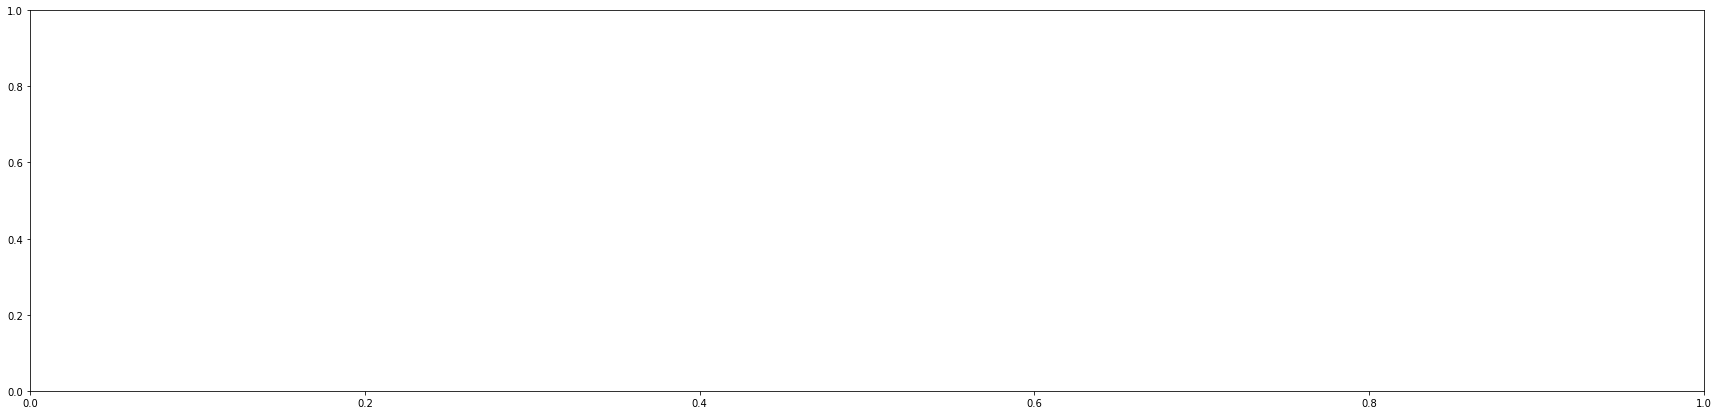

In [41]:
fig = plt.figure(figsize =(30, 7))
ax = fig.add_subplot(111)


data = [total_times_lat_lon_year_month_01,
        total_times_lat_lon_year_month_025,
        total_times_lat_lon_year_month_05,
        total_times_lat_lon_year_month_1,
       total_times_lat_lon_year_month_3,
       total_times_lat_lon_year_month_6,
       total_times_lat_lon]

# x-axis labels
ax.set_xticklabels(['0.1x0.1 degree partition','0.25x0.25 degree partition','0.5x0.5 degree partition',
                   '1x1 degree partition','3x3 degree partition','6x6 degree partition','1x1 degree partition without year month (baseline)'])
# Creating plot
plt.boxplot(data)


plt.title("Extract time + refine time")
ax.set_ylabel('processing time')

# show plot
plt.show()

In [ ]:
fig = plt.figure(figsize =(30, 7))
ax = fig.add_subplot(111)

data = [total_times_lat_lon_year_month_1,
       total_times_lat_lon_year_month_075075,
        total_times_lat_lon_year_month_1075,
        total_times_lat_lon_year_month_07506,
        total_times_lat_lon_year_month_07505,
        total_times_lat_lon_year_month_0606,
        total_times_lat_lon_year_month_0605,
       total_times_lat_lon_year_month_05]


# x-axis labels
ax.set_xticklabels(['1x1 degree partition','0.75x0.75 degree partition','1x0.5 degree partition',
                   '0.75x0.6 degree partition','0.75x0.5 degree partition','0.6x0.6 degree partition',
                    '0.6x0.5 degree partition','0.5x0.5 degree partition'])
# Creating plot
plt.boxplot(data)


plt.title("Extract time + refine time")
ax.set_ylabel('processing time')

# show plot
plt.show()

In [ ]:
ext_time = [np.median(ext_times_lat_lon_year_month_6),
np.median(ext_times_lat_lon_year_month_3),
np.median(ext_times_lat_lon_year_month_1),
np.median(ext_times_lat_lon_year_month_105),
np.median(ext_times_lat_lon_year_month_075075),
np.median(ext_times_lat_lon_year_month_07506),
np.median(ext_times_lat_lon_year_month_07505),
np.median(ext_times_lat_lon_year_month_0606),
np.median(ext_times_lat_lon_year_month_0605),
np.median(ext_times_lat_lon_year_month_05)
np.median(ext_times_lat_lon_year_month_025),
np.median(ext_times_lat_lon_year_month_01)]

In [ ]:
refine_time = [np.median(refine_times_lat_lon_year_month_6),
np.median(refine_times_lat_lon_year_month_3),
np.median(refine_times_lat_lon_year_month_1),
np.median(refine_times_lat_lon_year_month_105),
np.median(refine_times_lat_lon_year_month_075075),
np.median(refine_times_lat_lon_year_month_07506),
np.median(refine_times_lat_lon_year_month_07505),
np.median(refine_times_lat_lon_year_month_0606),
np.median(refine_times_lat_lon_year_month_0605),
np.median(refine_times_lat_lon_year_month_05)
np.median(refine_times_lat_lon_year_month_025),
np.median(refine_times_lat_lon_year_month_01)]

In [ ]:
total_process_time = np.array(ext_time) + np.array(refine_time)

In [ ]:
fig = plt.figure(figsize =(10, 5))
ax = fig.add_subplot(111)

plt.title("Partition size curve")
ax.set_ylabel('processing time')
ax.set_xlabel('partition size (log(x)).')
plt.plot(list(map(lambda x: np.log(x), partition_size)), process_time) 
plt.savefig('partition size curve.png')

In [ ]:
fig = plt.figure(figsize =(10, 5))
ax = fig.add_subplot(111)

plt.title("Partition size curve")
ax.set_ylabel('processing time')
ax.set_xlabel('partition size (log(x)).')
plt.plot(list(map(lambda x: np.log(x), partition_size)), refine_process_time) 
plt.savefig('partition size curve.png')